# Задача 1.3
## Агафонов Артём

In [1]:
import imageio as io
import numpy as np
import sys
from skimage.io import imread_collection
from scipy.stats import wilcoxon, median_test
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.sandbox.stats.multicomp import multipletests
from matplotlib import pyplot as plt
%matplotlib inline

### Чтение данных 

In [2]:
path = 'images_full/images/*.bmp'
all_pics = imread_collection(path)
all_pics.files

['images_full/images/modified_4249533_problem.bmp',
 'images_full/images/modified_5704145_company.bmp',
 'images_full/images/modified_5808690_fact.bmp',
 'images_full/images/modified_7491332_life.bmp',
 'images_full/images/modified_8521657_work.bmp',
 'images_full/images/modified_8552431_point.bmp',
 'images_full/images/modified_8801694_case.bmp',
 'images_full/images/modified_9290497_man.bmp',
 'images_full/images/modified_9522178_group.bmp',
 'images_full/images/modified_10721260_case.bmp',
 'images_full/images/modified_11339765_day.bmp',
 'images_full/images/modified_11345292_case.bmp',
 'images_full/images/modified_11939281_year.bmp',
 'images_full/images/modified_12179896_work.bmp',
 'images_full/images/modified_12295284_number.bmp',
 'images_full/images/modified_12822541_hand.bmp',
 'images_full/images/modified_15474125_woman.bmp',
 'images_full/images/modified_16676385_person.bmp',
 'images_full/images/modified_18111811_fact.bmp',
 'images_full/images/modified_18973166_child.bmp

In [3]:
len(all_pics)

2000

In [4]:
all_pics.files[0]

'images_full/images/modified_4249533_problem.bmp'

In [5]:
all_pics.files[1000]

'images_full/images/original_4249533.bmp'

Посмотрим на среднию разницу между значениями в пикселях.

In [6]:
for i in range(1000):
    orig_path = all_pics.files[i]
    modif_path = all_pics.files[1000 + i]
    orig = np.asarray(io.imread(orig_path), dtype = int)
    modif = np.asarray(io.imread(modif_path), dtype = int)
    diff = np.mean(orig - modif)
    print('i = {} diff = {}'.format(i, diff))

i = 0 diff = -0.02099609375
i = 1 diff = -0.000732421875
i = 2 diff = -0.0107421875
i = 3 diff = -0.03125
i = 4 diff = -0.004150390625
i = 5 diff = 0.005126953125
i = 6 diff = 0.01806640625
i = 7 diff = 0.022705078125
i = 8 diff = 0.008056640625
i = 9 diff = 0.01806640625
i = 10 diff = -0.028564453125
i = 11 diff = -0.0244140625
i = 12 diff = 0.0087890625
i = 13 diff = -0.008544921875
i = 14 diff = 0.012939453125
i = 15 diff = -0.00341796875
i = 16 diff = 0.01953125
i = 17 diff = 0.00732421875
i = 18 diff = 0.018310546875
i = 19 diff = -0.04296875
i = 20 diff = -0.0048828125
i = 21 diff = -0.00244140625
i = 22 diff = -0.0224609375
i = 23 diff = -0.02783203125
i = 24 diff = 0.016357421875
i = 25 diff = 0.02490234375
i = 26 diff = -0.005126953125
i = 27 diff = -0.04443359375
i = 28 diff = -0.000732421875
i = 29 diff = -0.00244140625
i = 30 diff = -0.014892578125
i = 31 diff = -0.0009765625
i = 32 diff = 0.033447265625
i = 33 diff = 0.008056640625
i = 34 diff = -0.0244140625
i = 35 diff =

In [7]:
modif - orig

array([[-1,  1,  0, ...,  1, -1, -2],
       [ 1,  0,  0, ...,  0, -1,  1],
       [-1,  0,  2, ..., -1, -1, -1],
       ...,
       [ 0,  0,  0, ...,  2,  0,  1],
       [ 1,  0,  0, ...,  1, -1,  1],
       [-1,  1,  1, ...,  0,  0,  0]])

Найдем пары фотографий с достаточно большим значением среднего отклонения по пикселям от $0$. Это кандидаты на наличие сообщения в их тексте. Малое отклонение говорит о случайности.

In [8]:
for i in range(1000):
    orig_path = all_pics.files[i]
    modif_path = all_pics.files[1000 + i]
    orig = np.asarray(io.imread(orig_path), dtype = int)
    modif = np.asarray(io.imread(modif_path), dtype = int)
    diff = np.mean(orig - modif)
    if abs(diff) > 0.5:
        print('i = {} diff = {}'.format(i, diff))

i = 141 diff = 45.13427734375
i = 178 diff = 21.9169921875
i = 182 diff = 39.909423828125
i = 538 diff = 20.4619140625
i = 555 diff = 42.250244140625
i = 599 diff = 21.902099609375
i = 829 diff = 20.31787109375
i = 847 diff = 35.051025390625
i = 861 diff = 22.017578125
i = 910 diff = 18.077880859375


Получилость так, что их ровно $1$%.

### Попробуем отобрать картинки с сообщениями с помощью статистических тестов: уилкокосона и теста знаков.

In [9]:
for i in range(1000):
    orig_path = all_pics.files[i]
    modif_path = all_pics.files[1000 + i]
    orig = np.asarray(io.imread(orig_path), dtype = int)
    modif = np.asarray(io.imread(modif_path), dtype = int)
    p_val = wilcoxon(orig.flatten(), modif.flatten())[1]
    if (p_val < 0.01):
        print('i = {} p-value = {:.6f} mean_diff = {}'.format(i, p_val, np.mean(orig.flatten() -  modif.flatten())))

i = 141 p-value = 0.000000 mean_diff = 45.13427734375
i = 178 p-value = 0.000000 mean_diff = 21.9169921875
i = 182 p-value = 0.000000 mean_diff = 39.909423828125
i = 394 p-value = 0.000647 mean_diff = -0.076416015625
i = 492 p-value = 0.009784 mean_diff = 0.05126953125
i = 519 p-value = 0.006879 mean_diff = 0.061279296875
i = 538 p-value = 0.000000 mean_diff = 20.4619140625
i = 555 p-value = 0.000000 mean_diff = 42.250244140625
i = 590 p-value = 0.000125 mean_diff = -0.07861328125
i = 599 p-value = 0.000000 mean_diff = 21.902099609375
i = 612 p-value = 0.000453 mean_diff = 0.075439453125
i = 829 p-value = 0.000000 mean_diff = 20.31787109375
i = 842 p-value = 0.007405 mean_diff = 0.0517578125
i = 847 p-value = 0.000000 mean_diff = 35.051025390625
i = 861 p-value = 0.000000 mean_diff = 22.017578125
i = 910 p-value = 0.000000 mean_diff = 18.077880859375
i = 953 p-value = 0.002218 mean_diff = 0.064697265625
i = 997 p-value = 0.005856 mean_diff = 0.064208984375


In [11]:
for i in range(1000):
    orig_path = all_pics.files[i]
    modif_path = all_pics.files[1000 + i]
    orig = np.asarray(io.imread(orig_path), dtype = int)
    modif = np.asarray(io.imread(modif_path), dtype = int)
    p_val = sign_test(orig.flatten() - modif.flatten())[1]
    if (p_val < 0.01):
        print('i = {} p-value = {:.6f} mean_diff = {}'.format(i, p_val, np.mean(orig.flatten() -  modif.flatten())))

i = 141 p-value = 0.000000 mean_diff = 45.13427734375
i = 172 p-value = 0.003631 mean_diff = -0.050048828125
i = 178 p-value = 0.000000 mean_diff = 21.9169921875
i = 182 p-value = 0.000000 mean_diff = 39.909423828125
i = 394 p-value = 0.002909 mean_diff = -0.076416015625
i = 519 p-value = 0.007817 mean_diff = 0.061279296875
i = 538 p-value = 0.000000 mean_diff = 20.4619140625
i = 555 p-value = 0.000000 mean_diff = 42.250244140625
i = 590 p-value = 0.000448 mean_diff = -0.07861328125
i = 599 p-value = 0.000000 mean_diff = 21.902099609375
i = 612 p-value = 0.000390 mean_diff = 0.075439453125
i = 829 p-value = 0.000000 mean_diff = 20.31787109375
i = 840 p-value = 0.002280 mean_diff = -0.03857421875
i = 847 p-value = 0.000000 mean_diff = 35.051025390625
i = 861 p-value = 0.000000 mean_diff = 22.017578125
i = 910 p-value = 0.000000 mean_diff = 18.077880859375
i = 953 p-value = 0.004591 mean_diff = 0.064697265625


 Видим, что оба теста оставили некоторые значения с достаточно малой разницей (и относительно большим p-value) по сравнению с остальными. Действительно, некоторые значения отличаются на целых $3$ порядка ($22.017578125 >> 0.075439453125$).
 
 Такие картинки лучше откинуть, ведь далее планируется использование МНК для нахождения коэффициента альфа:  
 $$modified.flatten() = original.flatten() + \alpha\cdot message + noise.$$
 А если в некоторых картинках не будт секретного послания, то это может сильно повлиять на качество МНК.
 
 Заметим, что нам лучше отобрать малое число примеров в которых мы будем точно уверены, нежели взять большую выборку но с каким-то процентом картинок без скрытых сообщений. Но при этом и число отобранных изображений не должно быть слишком маленьким, ведь по условию шум есть во всех модифицированых изображениях.
 
Сделаем поправку Холма на множественую проверку гипотез.

In [12]:
all_ps = []
for i in range(1000):
    orig_path = all_pics.files[i]
    modif_path = all_pics.files[1000 + i]
    orig = np.asarray(io.imread(orig_path), dtype = int)
    modif = np.asarray(io.imread(modif_path), dtype = int)
    p_val = sign_test(orig.flatten() - modif.flatten())[1]
    all_ps.append(p_val)

In [13]:
corrected  = multipletests(all_ps, alpha = 0.05, method = 'holm')

In [14]:
small_ps = [i for i, x in enumerate(corrected[0]) if x]
print(small_ps)

[141, 178, 182, 538, 555, 599, 829, 847, 861, 910]


Как раз получился $1$%.

### Подготовим данные для МНК

Распарсим названия файлов, чтобы получить зашифрованные слова, на которых будет потом обучать МНК.

In [15]:
words = []
for i in small_ps:
    tmp = all_pics.files[i+1000].replace('images_full/images/original_','')
    tmp = tmp.replace('.bmp', '')
    tmp2 = all_pics.files[i].replace('images_full/images/modified_','')
    tmp2 = tmp2.replace('.bmp', '')
    tmp2 = tmp2.replace(tmp, '')
    tmp2 = tmp2.replace('_', '')
    words.append(tmp2)
    print(tmp2)

group
life
part
fact
person
life
fact
number
life
hand


Закодируем слова и переодично продлим до длины картинки

In [16]:
size = np.asarray(io.imread(all_pics.files[0]), dtype = int).flatten().shape[0]
messages = []
for w in  words:
    length = len(w)
    w = list(w)
    m = []
    i = 0
    while(i < size):
        m.append(ord(w[i%length]) - 97)
        i += 1
    messages.append(m)

Создадим два больших вектора: первый состоит из законкаченных периодично продленных кодов слов, второй из законкаченных попиксильных разниц.

In [17]:
all_ms = []
all_diffs = []
for (m, i) in zip(messages, small_ps):
    all_ms += m
    
    orig_path = all_pics.files[i]
    modif_path = all_pics.files[1000 + i]
    orig = np.asarray(io.imread(orig_path), dtype = int)
    modif = np.asarray(io.imread(modif_path), dtype = int)
    all_diffs += list(orig.flatten() - modif.flatten())
print('LEN OF CONCATED MESSGAGES = {} '.format(len(all_ms)))
print('LEN OF CONCATED IMGS DIFFNS = {} '.format(len(all_diffs)))

LEN OF CONCATED MESSGAGES = 40960 
LEN OF CONCATED IMGS DIFFNS = 40960 


### Применим МНК

In [18]:
all_diffs = np.asarray(all_diffs)
all_ms = np.asarray(all_ms)

In [19]:
all_ms

array([ 6, 17, 14, ...,  0, 13,  3])

In [20]:
simple_model = OLS(all_diffs, all_ms).fit()

In [21]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          5.993e+06
Date:                Fri, 15 May 2020   Prob (F-statistic):                        0.00
Time:                        22:28:18   Log-Likelihood:                     -1.0155e+05
No. Observations:               40960   AIC:                                  2.031e+05
Df Residuals:                   40959   BIC:                                  2.031e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.1338      0.001   2447.966      0.000       3.131       3.136
==============================================================================
Omnibus:                    22477.482   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1869239.399
Skew:                          -1.778   Prob(JB):                         0.00
Kurtosis:                      35.903   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

По таблице видим, что получили коэффициент $\alpha = 3.1338$.

In [22]:
alpha = float(simple_model.summary().tables[1].data[1][1])

In [23]:
original_test = io.imread('images_full/original_test.bmp')
modified_test = io.imread('images_full/modified_test.bmp')
original_test = np.asarray(original_test,  dtype = int)
modified_test = np.asarray(modified_test,  dtype = int)

In [24]:
answ = ((modified_test - original_test) / alpha).round()

### Найдем периодичность

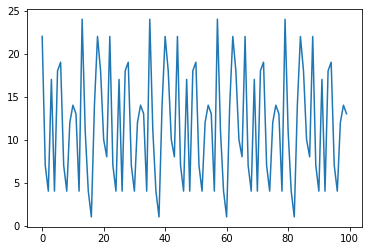

In [25]:
_ = plt.plot(answ.flatten()[:100])

Видим, что в векторе, содержащем попиксельную разницу между тестовой модифицированной и немодифицированной картинками есть периодичность.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


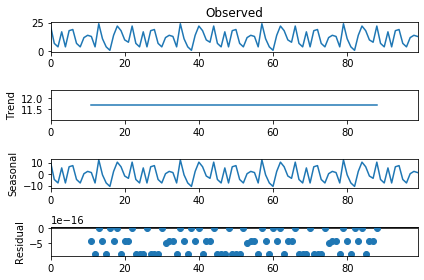

In [26]:
stl_data = seasonal_decompose(answ.flatten()[:100], freq=22)
_= stl_data.plot()

Период, а значит и длина фразы, равен $22$.

In [27]:
n_rows = int((len(answ.flatten()) / 22))
for row in answ.flatten()[: n_rows * 22].reshape(n_rows, 22):
    for i in row:
        print(chr(int(i) + 97), end = ' ')
    print('\n')

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b o w s k i 

w h e r e s t h e m o n e y l e b 

###  Нам удалось расшифровать сообщение:   where's the money lebowski.